# Trees and Forests

This notebook gives an introduction to decision and regression trees and their aggregation as forests. We will implement a bagging (Bootstrap AGGregating) algorithm ourselves, construct a random forest ourselves and finally use a random forest from a standard package.

In [1]:
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random

## Decision Trees

In a classification of discrete classes, one intuitively might want to find some simple rules based on the instances' features. E.g., if we wónly have biological data such as weight, height, eye colour etc. and want to estimate, whether the person is male or female, one might intuitively come to decision rules like: "If height > 180 cm, it's probably a man." or "If weight < 50 kg, it's probably a woman."

Decision trees formalise this strategy: At each node, they try to find a pair of feature x_i and threshold value t so that the split into two groups "x_i < t" and "x_i > t" decreases the impurity of the two new groups the most compared to the initial sample. The impurity is usually measured by the Shannon Entropy or the Gini index. Because the construction of the tree requires knowledge about the true label, the decision tree is a supervised ML method.

Gini and Entropy are calculated based on the relative share $p_i$ of the class i in the current node's subsample. The Gini G is given by $G(\vec{p}) = -\sum_i p_i^2$ and the Entropy $S$ by $S(\vec{p}) =  -\sum_i p_i \log_2{p_i}$. Both are minimised by $p_j=1$ and all other $p_l=0$ (i.e. a pure set) and maximised by $p=i = \frac{1}{n}$ for all i (uniform distribution).

Here, we will see an example of a decision tree trying to separate three species of plants in the classic Iris dataset.

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

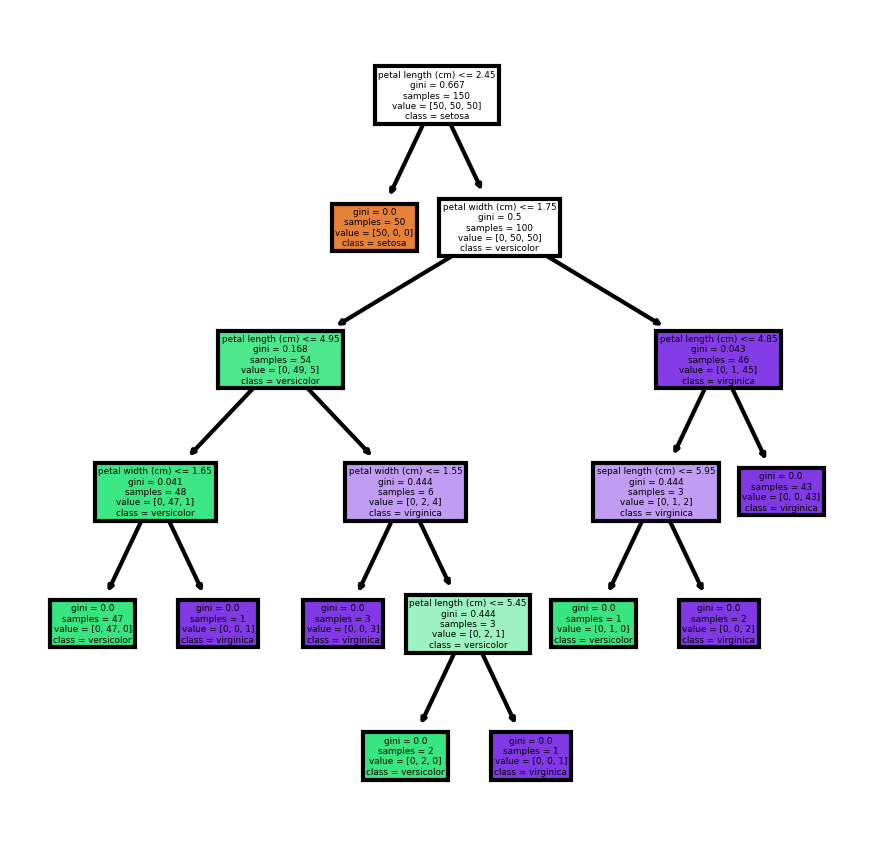

In [3]:

# Setting dpi higher to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3.5,3.5), dpi=300)

# manually setting the class names and feature names

fn=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']
cn=['setosa', 'versicolor', 'virginica']

tree.plot_tree(clf,
           feature_names = fn, 
           class_names=cn,
           filled = True)
plt.show()

The visualisation provides us with a useful interpretation of the decision tree and helps to explain its results to anyone, even if they do not have any statistical training: The first split is on petal width being smaller or larger than 0.8 cm. The smaller ones are sorted into the left box, which is already 100% pure (indicated by the [50, 0, 0] frequency table and its pure colour). The right box contains the other 100 instances from the sample and is split again on petal width, but now with a different threshold (1.75). Then, the tree splits on petal length in its third layer and so on.

Because after the second split on petal width, the three subsamples are almost pure (the pure [50,0,0] from the first split and the new [0,49,5] and [0,1,45] from the second split). Therefore, it is fair to conclude that petal width is the most useful feature to separate between instances in this data set. Generally, the earler a feature appears in the tree, the more useful it is.

### Now with Entropy instead of Gini
Do our results change?

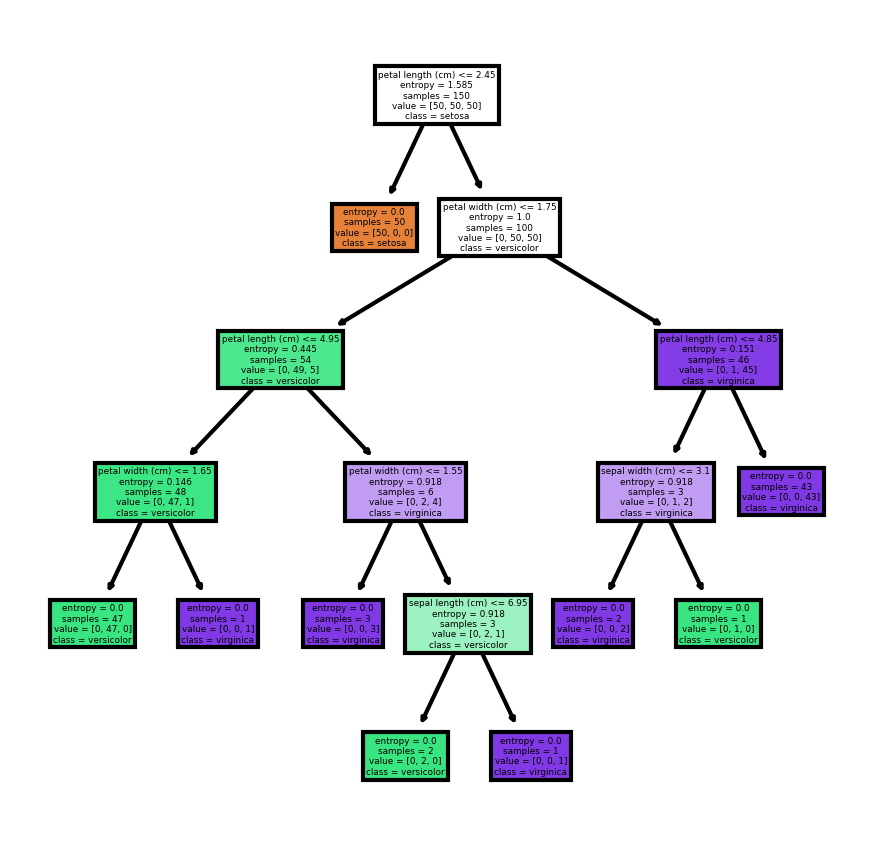

In [4]:
clf = tree.DecisionTreeClassifier(criterion = "entropy")
clf = clf.fit(X, y)


# Setting dpi higher to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3.5,3.5), dpi=300)

# manually setting the class names and feature names

fn=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']
cn=['setosa', 'versicolor', 'virginica']

tree.plot_tree(clf,
           feature_names = fn, 
           class_names=cn,
           filled = True)
plt.show()

The first three splitting layers are the same, but there are some changes in the deeper (and less relevant) layers.

## Predictions and Pruning the Tree

In this example, the tree splits until there are only pure "leaves" left, i.e. until each terminal node only contains one class. If the data is large and difficult to separate, this can lead to increadibly large and detailed trees, which take long to train and are difficult to interpret. If we use this tree to predict a new instance, the instance will be sorted into one of the leaves and the classifier will predict that it is the same class as the other instances in that leave.

Also, this is likely to lead to overfitting, because even in our simple example, we have several leaves that only contain one or two instances, but that is not really a trustworthy sample size to base your prediction on. Instead, one can set a maximum depth of the tree to limit its size. If there are unpure terminal nodes left, the prediction of the tree will simply correspond to the majority class of the terminal nodes. Reducing a tree's size is called "pruning".

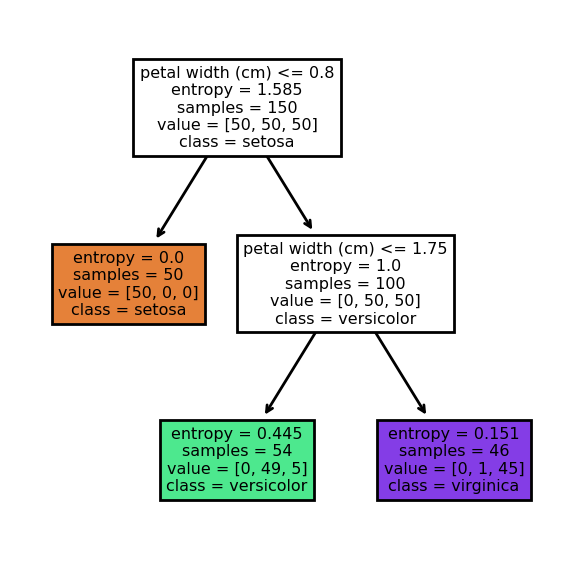

In [5]:
# for the full data

clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 2)
clf = clf.fit(X, y)


# Setting dpi higher to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3.5,3.5), dpi=200)

# manually setting the class names and feature names

fn=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']
cn=['setosa', 'versicolor', 'virginica']

tree.plot_tree(clf,
           feature_names = fn, 
           class_names=cn,
           filled = True)
plt.show()

### Testing the Prediction

We will now split the full data into a training and testing set and train two trees on them: The first one has no maximum depth, whereas the second one will have maximum depth of 2 (like in the examples above). We will evaluate on the test data, which of the classifiers performs better.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [7]:
# The full tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf_full = clf.fit(X_train, y_train)

# the reduced tree 
clf = tree.DecisionTreeClassifier(max_depth = 2,random_state=0)
clf_prune = clf.fit(X_train, y_train)



In [8]:
# Make predictions
y_full = clf_full.predict(X_test)
y_prune = clf_prune.predict(X_test)

In [9]:
print("If this is nonzero, the classifiers have made different predictions:", len(y_full)-sum(y_full == y_prune))

If this is nonzero, the classifiers have made different predictions: 1


In [10]:
# Check against the true value for y_test
Accuracy_full = sum(y_full == y_test)/len(y_test)
Accuracy_prune = sum(y_prune == y_test)/len(y_test)

print("The full tree has an accuracy of", Accuracy_full.round(3), "whereas the pruned tree has an accuracy of",Accuracy_prune.round(3))

if Accuracy_full > Accuracy_prune:
    print("The full tree achieves a higher accuracy.")
elif Accuracy_full < Accuracy_prune:
    print("The pruned tree achieves a higher accuracy: the full tree is overfitting the data!")
else:
    print("Both trees are equally good predictors.")

The full tree has an accuracy of 0.967 whereas the pruned tree has an accuracy of 0.983
The pruned tree achieves a higher accuracy: the full tree is overfitting the data!


## Different Data Set: Titanic

In [11]:
data = pd.read_csv(
    'https://github.com/datagy/data/raw/main/titanic.csv', 
    usecols=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked'])
data = data.dropna()
print(data.shape, X.shape)
# This is much larger than the Iris data

y = data["Survived"]
del data["Survived"]
X = data
print(X)

(712, 7) (150, 4)
     Pclass     Sex   Age  SibSp     Fare Embarked
0         3    male  22.0      1   7.2500        S
1         1  female  38.0      1  71.2833        C
2         3  female  26.0      0   7.9250        S
3         1  female  35.0      1  53.1000        S
4         3    male  35.0      0   8.0500        S
..      ...     ...   ...    ...      ...      ...
885       3  female  39.0      0  29.1250        Q
886       2    male  27.0      0  13.0000        S
887       1  female  19.0      0  30.0000        S
889       1    male  26.0      0  30.0000        C
890       3    male  32.0      0   7.7500        Q

[712 rows x 6 columns]


This data has categorical features. We need to convert them to floats, e.g. via OneHotEncoding.

In [12]:
X = pd.get_dummies(X)
print(X)

     Pclass   Age  SibSp     Fare  Sex_female  Sex_male  Embarked_C  \
0         3  22.0      1   7.2500           0         1           0   
1         1  38.0      1  71.2833           1         0           1   
2         3  26.0      0   7.9250           1         0           0   
3         1  35.0      1  53.1000           1         0           0   
4         3  35.0      0   8.0500           0         1           0   
..      ...   ...    ...      ...         ...       ...         ...   
885       3  39.0      0  29.1250           1         0           0   
886       2  27.0      0  13.0000           0         1           0   
887       1  19.0      0  30.0000           1         0           0   
889       1  26.0      0  30.0000           0         1           1   
890       3  32.0      0   7.7500           0         1           0   

     Embarked_Q  Embarked_S  
0             0           1  
1             0           0  
2             0           1  
3             0           1

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)

In [14]:
# The full tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf_full = clf.fit(X_train, y_train)
del clf

# the reduced tree 
clf = tree.DecisionTreeClassifier(max_depth = 2,random_state=0)
clf_prune = clf.fit(X_train, y_train)
del clf
# check the predictions on the training data:

y_full = clf_full.predict(X_train)
y_prune = clf_prune.predict(X_train)
Acc_train_full = sum(y_full == y_train)/len(y_train)
Acc_train_prune = sum(y_prune == y_train)/len(y_train)
print("On the training data, the full tree has an accuracy of", np.round(Acc_train_full,3), 
     "whereas the pruned tree only has an accuracy of", np.round(Acc_train_prune,3))


# Make predictions
y_full = clf_full.predict(X_test)
y_prune = clf_prune.predict(X_test)

# Check against the true value for y_test
Accuracy_full = sum(y_full == y_test)/len(y_test)
Accuracy_prune = sum(y_prune == y_test)/len(y_test)


print("For the prediction on the test data:")
print("The full tree has an accuracy of", np.round(Accuracy_full,3), "whereas the pruned tree has an accuracy of",np.round(Accuracy_prune,3))

if Accuracy_full > Accuracy_prune:
    print("The full tree achieves a higher accuracy.")
elif Accuracy_full < Accuracy_prune:
    print("The pruned tree achieves a higher accuracy: the full tree is overfitting the data!")
else:
    print("Both trees are equally good predictors.")

On the training data, the full tree has an accuracy of 0.991 whereas the pruned tree only has an accuracy of 0.803
For the prediction on the test data:
The full tree has an accuracy of 0.751 whereas the pruned tree has an accuracy of 0.789
The pruned tree achieves a higher accuracy: the full tree is overfitting the data!


The larger sample size and number of features makes the difference between the full and pruned tree become more evident.

# Bagging

The idea behind bagging is that many weak classifiers can be combined to one strong classifier. To get many different weak classifiers, we use a technique called bootstrapping: For each new classifier, we resample our dataset with replacement and train it on this "bootstrapped" sample. This means that some instances will appear more than once in the data, but others do not appear at all. While this may seem strange, it will result in a variety of estimators that will cancel out each other's mistakes.

Then, we aggregate the classifiers by using the most frequent estimation of the ensemble of the weak classifiers. Bagging is a Portmanteau of these terms: Bootstrapp AGGregating.

In [15]:
X.iloc[711]

Pclass         3.00
Age           32.00
SibSp          0.00
Fare           7.75
Sex_female     0.00
Sex_male       1.00
Embarked_C     0.00
Embarked_Q     1.00
Embarked_S     0.00
Name: 890, dtype: float64

In [16]:
n_B = 100 # number of Bootstrapping

def Bootstrap(Features, Targets):
    N = len(Targets)    
    DF_target = pd.DataFrame(data={"Label": Targets})
    DF_target.index = np.arange(0,N)
    DF_Features = Features
    DF_Features.index = DF_target.index
    
    # combine feautures and targets to one object, because otherwise, the resampling will mix up the labels of each instance
    DF = pd.concat((DF_Features, DF_target) , axis = 1)
    
    # resampling
    selection = np.random.choice(np.arange(0,N), 
                                 size=N, replace=True)
    
    Out = DF.iloc[selection]
    Out.index = np.arange(0,N)
    
    Out_y = Out["Label"]
    del Out["Label"]
    
    return(list([Out, Out_y]))

In [17]:
BT_Xout, BT_yout = 0,0

In [18]:
def Bagged_Tree(xtrain, ytrain, xtest, nB, mdepth = 2):
    global Results, BT_Xout, BT_yout
    

    L = xtest.shape[0]
    Out = np.empty((nB, L)) # output of all predictions of all classifiers
                            # nth row: nth Bootstrapped classifier
                            # lth column: all predictions for instance x_test_l
    
    for i in range(nB):
        clf = tree.DecisionTreeClassifier(max_depth = mdepth)
        BT_X, BT_y = Bootstrap(xtrain, ytrain)
        BT_Xout, BT_yout = BT_X, BT_y
        clf_bt = clf.fit(BT_X, BT_y)
        y_hat_bt = clf_bt.predict(xtest)

        
        del clf_bt, BT_X, BT_y, clf
        Out[i,:] = y_hat_bt
    
    means = np.mean(Out, 0) # takes mean value for each column (0: column, 1: row)
    thresh = np.mean(means)
    means = 1.0*(means>thresh)   # > thresh checks if majority decision is closer to 1 or to 0
                              # 1.0* transforms Boolean True/False into numeric 1/0
        
    Results = Out
    return(means)

In [19]:
np.random.seed(2958) # to reproduce results
BT_result= Bagged_Tree(X_train, y_train, X_test, n_B, 2)

In [20]:
Acc_bagging = np.sum(BT_result == y_test)/len(y_test)

In [21]:
Accuracy_prune

0.7894736842105263

In [22]:
print("Does bagging achieve a higher accuracy than the pruned tree?", np.round(Acc_bagging,3), "for bagging and", 
     np.round(Accuracy_prune,3), "for pruning.")
print("In this example: no, it does not.")

Does bagging achieve a higher accuracy than the pruned tree? 0.765 for bagging and 0.789 for pruning.
In this example: no, it does not.


### Third Data Set

Let's try the Bagging for a breast cancer data set.

In [23]:
Cancer = load_breast_cancer()
X_C, y_C = Cancer["data"], Cancer["target"]
X_C = pd.DataFrame(X_C)
y_C  = pd.Series(y_C)
print(X_C, y_C)

        0      1       2       3        4        5        6        7       8   \
0    17.99  10.38  122.80  1001.0  0.11840  0.27760  0.30010  0.14710  0.2419   
1    20.57  17.77  132.90  1326.0  0.08474  0.07864  0.08690  0.07017  0.1812   
2    19.69  21.25  130.00  1203.0  0.10960  0.15990  0.19740  0.12790  0.2069   
3    11.42  20.38   77.58   386.1  0.14250  0.28390  0.24140  0.10520  0.2597   
4    20.29  14.34  135.10  1297.0  0.10030  0.13280  0.19800  0.10430  0.1809   
..     ...    ...     ...     ...      ...      ...      ...      ...     ...   
564  21.56  22.39  142.00  1479.0  0.11100  0.11590  0.24390  0.13890  0.1726   
565  20.13  28.25  131.20  1261.0  0.09780  0.10340  0.14400  0.09791  0.1752   
566  16.60  28.08  108.30   858.1  0.08455  0.10230  0.09251  0.05302  0.1590   
567  20.60  29.33  140.10  1265.0  0.11780  0.27700  0.35140  0.15200  0.2397   
568   7.76  24.54   47.92   181.0  0.05263  0.04362  0.00000  0.00000  0.1587   

          9   ...      20  

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_C, y_C, test_size = 0.9, #test_size=0.4,
                                                    random_state=12345)

In [25]:
BT_result= Bagged_Tree(X_train, y_train, X_test, n_B, 2)

In [26]:
Acc_Bagging = np.sum(BT_result == y_test)/len(y_test)

In [27]:
# Comparison: regular pruned tree
clf = tree.DecisionTreeClassifier(max_depth = 2)
clf_Cancer = clf.fit(X_train, y_train)
y_hat_Cancer = clf_Cancer.predict(X_test)
Acc_Cancer_Prune = np.mean(y_hat_Cancer == y_test) 

In [28]:
print("For this data, the bagging accuracy", np.round(Acc_Bagging,3), "is higher than the pruning accuracy", 
      np.round(Acc_Cancer_Prune,3))

For this data, the bagging accuracy 0.92 is higher than the pruning accuracy 0.914


# Random Forests

Random Forests are similar to the Bagging algorithm, but for each bootstrapping, they also choose a random subset of the features. The tree is only constructed with this random feature subset. This trades a higher bias for a lower variance, i.e. that several iterations of random forests have very similar predictions, even though they might be a little bit away from the true prediction.

In [29]:
def RandomForest(xtrain, ytrain, xtest, nB, nRF = 3,mdepth = 2):
    global Results, BT_Xout, BT_yout
    
    # nRF is the number of features that are sampled for each bootstrapped instance sample
    

    L = xtest.shape[0]
    Out = np.empty((nB, L)) # output of all predictions of all classifiers
                            # nth row: nth Bootstrapped classifier
                            # lth column: all predictions for instance x_test_l
    
    for i in range(nB):
        clf = tree.DecisionTreeClassifier(max_depth = mdepth)
        # sample the random features
        Features = np.random.choice(X_C.columns,nRF,
                                    replace = False)
        BT_X, BT_y = Bootstrap(xtrain[Features],
                               ytrain)
        BT_Xout, BT_yout = BT_X, BT_y
        clf_bt = clf.fit(BT_X, BT_y)
        y_hat_bt = clf_bt.predict(xtest[Features])

        
        del clf_bt, BT_X, BT_y, clf
        Out[i,:] = y_hat_bt
    
    means = np.mean(Out, 0) # takes mean value for each column (0: column, 1: row)
    thresh = np.mean(means)
    means = 1.0*(means>thresh)   # > thresh checks if majority decision is closer to 1 or to 0
                              # 1.0* transforms Boolean True/False into numeric 1/0
        
    Results = Out
    return(means)

In [30]:
# Check that the Feature Selection actually changes something
for i in range(1,10):
    print(RandomForest(X_train, y_train, X_test, n_B, nRF = i)[20:30])

[1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
[0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]


In [31]:
y_RF_hat = RandomForest(X_train, y_train, X_test, n_B, nRF = 2)

In [32]:
Acc_RF = np.sum(y_RF_hat == y_test)/len(y_test)

In [33]:
print("The Random Forest achieves an accuracy of", np.round(Acc_RF,3),
      "while the Bagging classifier has an accuracy of", np.round(Acc_Bagging,3))

The Random Forest achieves an accuracy of 0.918 while the Bagging classifier has an accuracy of 0.92


## sklearn's Random Forest

Of course, sklearn also has an implementation for the random forest:

In [34]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [35]:
clf = RFC(n_estimators = n_B,
         criterion = "gini",
         max_depth = 3)  # Of course, one can play with these hyperparameters
sklearnRF = clf.fit(X_train, y_train)
y_hat_sRF = sklearnRF.predict(X_test)
Acc_hat_sRF = np.mean(y_hat_sRF == y_test)

In [36]:
print("sklearn's Random Forest has an accuracy of",np.round(Acc_hat_sRF,3))

sklearn's Random Forest has an accuracy of 0.93
